In [ ]:
%matplotlib inline
# !pip install numpy
# !pip install torch
# !pip install scikit-learn


# Introduction to Deep Learning in Pytorch


PyTorch provides the elegantly designed modules and classes [torch.nn](https://pytorch.org/docs/stable/nn.html) ,
[torch.optim](https://pytorch.org/docs/stable/optim.html) ,
[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) ,
and [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)
to help you create and train neural networks.

In order to fully utilize their power and customize
them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net
on the digits data set without using any features from these models; we will
initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

**This tutorial assumes you already have PyTorch installed, and are familiar
with the basics of tensor operations.** (If you're familiar with Numpy array
operations, you'll find the PyTorch tensor operations used here nearly identical).

## Digits Dataset setup

We will use the classic [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset,
a simplified version of the [mnist](http://deeplearning.net/data/mnist/) dataset provided by scikit-learn. 
which consists of black-and-white images of hand-drawn digits (between 0 and 9).


In [ ]:
from sklearn.datasets import load_digits
import numpy as np

x, y = load_digits(return_X_y=True)
print(x, y)

n_samples, n_features = x.shape
n_classes = len(np.unique(y))

print(f"Number of samples: {n_samples}, Number of features: {n_features}")
print(f"Labels range {y.min()} - {y.max()}, Number of classes: {n_classes}")

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] [0 1 2 ... 8 9 8]
Number of samples: 1797, Number of features: 64
Labels range 0 - 9, Number of classes: 10


Each image is 8 x 8, and is being stored as a flattened row of length 64. Let's take a look at one; we need to reshape it to 2d
first.






(1797, 64)


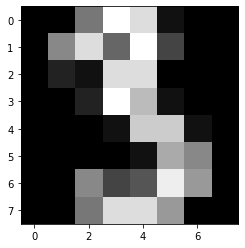

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x[3].reshape((8, 8)), cmap="gray")
print(x.shape)

The input data is stored with values in [0-16]. We need to normalize it in [0-1].

In [ ]:
def normalize(data):
  data = data - data.min()
  data = data/data.max()
  return data

x = normalize(x)
print(x)

[[0.     0.     0.3125 ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.625  0.     0.    ]
 [0.     0.     0.     ... 1.     0.5625 0.    ]
 ...
 [0.     0.     0.0625 ... 0.375  0.     0.    ]
 [0.     0.     0.125  ... 0.75   0.     0.    ]
 [0.     0.     0.625  ... 0.75   0.0625 0.    ]]


We have to split the dataset into training and validation. To do so we can use one of the many functions provided by scikit-learn. For example we can call ``sklearn.model_selection.StratifiedKFold()`` to have a cross validation generator. 

For the sake of simplicity, however, in this tutorial we will use ``sklearn.model_selection.train_test_split`` which performs a simple holdout cross-validation to create a single train test split (with 90% - 10% of data in this case)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [ ]:
import torch
x_train = torch.as_tensor(x_train, dtype=torch.float32)
x_valid = torch.as_tensor(x_valid, dtype=torch.float32)
y_train = torch.as_tensor(y_train, dtype=torch.long)
y_valid = torch.as_tensor(y_valid, dtype=torch.long)

## Neural networks from scratch (no torch.nn)

Let's first create a model using nothing but PyTorch tensor operations. We assume you're already familiar with the basics of neural networks. 

PyTorch provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
**gradient**. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation **automatically**!



### The Model

We will use a very simple logistic regression with 10 output nodes (as many as the number of classes).

For the weights, we set ``requires_grad`` after the initialization, since we
don't want that step included in the gradient. 

####To Note: 
1. We are initializing the weights here with the [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), by multiplying with 1/sqrt(n_features)).
2. The trailing ``_`` in PyTorch signifies that the operation is performed in-place (``requires_grad_()``)






In [ ]:
weights = torch.randn(n_features, n_classes) / np.sqrt(n_features)
bias = torch.randn(n_classes) / np.sqrt(n_features)
weights.requires_grad_()
bias.requires_grad_()

tensor([-0.1192,  0.0457, -0.0159, -0.0357,  0.1766, -0.0492, -0.1380,  0.0323,
        -0.0820,  0.2707], requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model!

Let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it.

Although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. 
PyTorch will even create fast GPU or vectorized CPU code for your function
**automatically**.


In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # => log(exp(x)/sum(exp(x_i)))

def model(xb):
    return log_softmax(xb @ weights + bias) # a @ b -> torch.matmul(a, b)

In the above, the ``@`` stands for the *matrix multiplication* operation. We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  

Note: our predictions won't be any better than
random at this stage, since we start with random weights and we have not done any training step.



In [ ]:
bs = 64               # batch size
xb = x_train[0:bs]    # a mini-batch from x
preds = model(xb)     # predictions
print(preds[0], preds.shape)
# print(preds)

tensor([-2.9939, -2.7773, -2.8725, -2.4019, -2.3797, -2.1038, -2.1037, -1.8490,
        -2.0108, -2.1824], grad_fn=<SelectBackward0>) torch.Size([64, 10])


As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do the backpropagation.


### Loss and Metric

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python). Note that the way in which we have implemented it is just a clever way of doing the selection of the prediction corresponding to the correct label as in: $\sum_i y_i * log(f_i)$. You can find further information on how to compute the cross entropy loss in different scenarios in this [tutorial](https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81).


If we check our loss with our random model now, we can see if we improve
after a backprop pass later.



In [ ]:
def nll(output, target):
    return -output[range(target.shape[0]), target].mean()

loss_func = nll
l = loss_func(model(x_train), y_train)
print(f"Initial Loss: {l}")

Initial Loss: 2.46158504486084


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.


In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean() * 100

acc = accuracy(model(x_train), y_train)
print(f"Initial Accuracy: {acc} %")

Initial Accuracy: 5.318490982055664 %


### The training loop

We can now run a training loop.  For each iteration, we will:

1. select a mini-batch of data (of size ``bs``)
2. use the model to make predictions
3. calculate the loss
4. ``loss.backward()`` computes the gradients of the model, in this case, ``weights`` and ``bias``.
5. update the parameters to optimize the model

Note:

- We do this within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
[here](https://pytorch.org/docs/stable/notes/autograd.html).
- We then set the gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).



In [ ]:
lr = .5  # learning rate
epochs = 20  # how many epochs to train for
train_samples = x_train.shape[0]

for epoch in range(epochs):
    for i in range((train_samples - 1) // bs + 1):
        
        ## select input and label batch
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        ## make predictions and compute loss
        pred = model(xb)
        loss = loss_func(pred, yb)
        ## compute gradient through backprop
        loss.backward()

        ## update gradients through SGD
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(f"Epoch {epoch}: {loss_func(model(x_train), y_train)}")

Epoch 0: 1.0195523500442505
Epoch 1: 0.6424251198768616
Epoch 2: 0.49227654933929443
Epoch 3: 0.41159969568252563
Epoch 4: 0.36043301224708557
Epoch 5: 0.32457679510116577
Epoch 6: 0.29775890707969666
Epoch 7: 0.2767714858055115
Epoch 8: 0.2597930431365967
Epoch 9: 0.24570578336715698
Epoch 10: 0.23378172516822815
Epoch 11: 0.2235240638256073
Epoch 12: 0.21458086371421814
Epoch 13: 0.2066950798034668
Epoch 14: 0.19967423379421234
Epoch 15: 0.19337092339992523
Epoch 16: 0.18767036497592926
Epoch 17: 0.18248164653778076
Epoch 18: 0.1777316927909851
Epoch 19: 0.17336124181747437


That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have. 



In [1]:
print(f"Loss after training: {loss_func(model(x_train), y_train)}")
print(f"Accuracy after training: {accuracy(model(x_train), y_train)}")

NameError: ignored

In [ ]:
start_i, end_i, train_samples

(1600, 1664, 1617)

## Let's refactor our code using torch.nn

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.




### Refactor using nn.functional
The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating deep neural
networks, such as pooling functions. 

If you're using negative log likelihood loss and log softmax activation,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:



In [ ]:
print(loss_func(model(x_train), y_train))

tensor(0.1734, grad_fn=<NllLossBackward0>)


### Refactor using nn.Module
Next up, we'll use ``nn.Module`` (*uppercase M*) and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of its attributes).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.

Since we're now using an object instead of just using a function, we
first have to instantiate our model:




In [ ]:
from torch import nn

class DigitsLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_features, n_classes) / np.sqrt(n_features))
        self.bias = nn.Parameter(torch.randn(n_classes) / np.sqrt(n_features))

    def forward(self, xb):
        return xb @ self.weights + self.bias
  
model = DigitsLogistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically, i.e.
```
  def __call__(self, *args, **kwargs):
    return self.forward(args, kwargs)
```



In [ ]:
print(loss_func(model(x_train), y_train), accuracy(model(x_train), y_train))

tensor(2.3002, grad_fn=<NllLossBackward0>) tensor(16.8213)


#### model.parameters() and model.zero_grad()

Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:
```
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()
```

Now we can take advantage of model.parameters() and model.zero_grad() to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
```
  with torch.no_grad():
      for p in model.parameters(): 
          p -= p.grad * lr
      model.zero_grad()
```

We'll wrap our little training loop in a ``fit`` function so we can run it
again later. And we double-check that our loss has gone down:


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((train_samples - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        print(f"Epoch: {epoch}, {loss_func(model(x_train), y_train)}")  

fit()
print(f"Accuracy: {accuracy(model(x_train), y_train)}")

Epoch: 0, 0.997830867767334
Epoch: 1, 0.6405810117721558
Epoch: 2, 0.49449464678764343
Epoch: 3, 0.4147348999977112
Epoch: 4, 0.36362701654434204
Epoch: 5, 0.3275809586048126
Epoch: 6, 0.3005152642726898
Epoch: 7, 0.27928435802459717
Epoch: 8, 0.2620857059955597
Epoch: 9, 0.24780532717704773
Epoch: 10, 0.23571372032165527
Epoch: 11, 0.22531098127365112
Epoch: 12, 0.21624189615249634
Epoch: 13, 0.20824648439884186
Epoch: 14, 0.20112967491149902
Epoch: 15, 0.19474202394485474
Epoch: 16, 0.18896688520908356
Epoch: 17, 0.18371187150478363
Epoch: 18, 0.1789027601480484
Epoch: 19, 0.17447920143604279
Accuracy: 96.72232055664062


### Refactor using nn.Linear

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
[nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



In [ ]:
class DigitsLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, n_classes)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [ ]:
model = DigitsLogistic()
print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

Loss: 2.312673568725586, Accuracy: 10.389610290527344


We are still able to use our same ``fit`` method as before.



In [ ]:
fit()
print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

Epoch: 0, 0.9985122680664062
Epoch: 1, 0.6358577609062195
Epoch: 2, 0.48931020498275757
Epoch: 3, 0.41006720066070557
Epoch: 4, 0.3596092760562897
Epoch: 5, 0.32415032386779785
Epoch: 6, 0.29757630825042725
Epoch: 7, 0.27674975991249084
Epoch: 8, 0.2598838210105896
Epoch: 9, 0.24587906897068024
Epoch: 10, 0.23401787877082825
Epoch: 11, 0.2238096296787262
Epoch: 12, 0.214906245470047
Epoch: 13, 0.20705312490463257
Epoch: 14, 0.2000594288110733
Epoch: 15, 0.19377902150154114
Epoch: 16, 0.18809786438941956
Epoch: 17, 0.18292570114135742
Epoch: 18, 0.17818991839885712
Epoch: 19, 0.1738315373659134
Loss: 0.1738315373659134, Accuracy: 96.78417205810547


## Refactor using optim

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
```
  with torch.no_grad():
      for p in model.parameters(): 
          p -= p.grad * lr
      model.zero_grad()
```

and instead use just:
```
# before the training loop
opt = optim.SGD(model.parameters(), lr=lr)

# in the training loop
opt.step()
opt.zero_grad()
```

``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.



In [ ]:
from torch import optim
model = DigitsLogistic()
opt = optim.SGD(model.parameters(), lr=lr)
print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

for epoch in range(epochs):
    for i in range((train_samples - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

Loss: 2.378992795944214, Accuracy: 12.121212005615234
Loss: 0.1739804446697235, Accuracy: 96.84600830078125


## Refactor using Dataset

PyTorch has an abstract Dataset class.  A Dataset can be anything that has:
*   a ``__len__`` function (called by Python's standard ``len`` function)
*   a ``__getitem__`` function as a way of indexing into it.

There are many pre-existing datasets in the [torchvision](https://pytorch.org/vision/stable/datasets.html) library. Otherwise you can also create your own.
[This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor.

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.


In [ ]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
```
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Now, we can do these two steps together:
```
    xb,yb = train_ds[i*bs : i*bs+bs] # we access all tensors in the dataset with one slicing
```



In [ ]:
model = DigitsLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i in range((train_samples - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs] 
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

Loss: 0.17380556464195251, Accuracy: 96.90785217285156


## Refactor using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.

Also Shuffling the training data is
[important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)
to prevent correlation between batches and overfitting. DataLoader provides the parameter ``shuffle=True`` to do it.



In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

Previously, our loop iterated over batches (xb, yb) like this:

      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:

      for xb,yb in train_dl:
          pred = model(xb)



In [ ]:
model = DigitsLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for xb, yb in train_dl: # we don't have to specify anymore nor bs nor train_samples
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(f"Loss: {loss_func(model(x_train), y_train)}, Accuracy: {accuracy(model(x_train), y_train)}")

Loss: 0.16964751482009888, Accuracy: 96.84600830078125


Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effective models in practice.

## Add validation

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a [validation set](https://www.fast.ai/2017/11/13/validation-sets/), in order
to identify if you are overfitting.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly by inserting the validation loop in a ``with torch.no_grad():``.



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2) # Non need to shuffle the Validation set

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model = DigitsLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

def fit(model, opt, epochs, loss_func, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            valid_losses, valid_accs = [], []
            for xb, yb in valid_dl:
                valid_losses.append(loss_func(model(xb), yb))
                valid_accs.append(accuracy(model(xb), yb))

        print(f"Epoch {epoch:.2f}: Val Loss {np.mean(valid_losses):.2f}, " 
              f"Val Acc: {np.mean(valid_accs):.2f}") 
        
fit(model, opt, epochs, loss_func, train_dl, valid_dl)


Epoch 0.00: Val Loss 1.03, Val Acc: 85.10
Epoch 1.00: Val Loss 0.63, Val Acc: 90.69
Epoch 2.00: Val Loss 0.50, Val Acc: 93.00
Epoch 3.00: Val Loss 0.42, Val Acc: 90.50
Epoch 4.00: Val Loss 0.37, Val Acc: 94.38
Epoch 5.00: Val Loss 0.33, Val Acc: 94.56
Epoch 6.00: Val Loss 0.31, Val Acc: 93.60
Epoch 7.00: Val Loss 0.30, Val Acc: 92.43
Epoch 8.00: Val Loss 0.29, Val Acc: 94.56
Epoch 9.00: Val Loss 0.26, Val Acc: 94.95
Epoch 10.00: Val Loss 0.26, Val Acc: 96.69
Epoch 11.00: Val Loss 0.24, Val Acc: 95.34
Epoch 12.00: Val Loss 0.22, Val Acc: 97.66
Epoch 13.00: Val Loss 0.22, Val Acc: 95.34
Epoch 14.00: Val Loss 0.21, Val Acc: 97.66
Epoch 15.00: Val Loss 0.22, Val Acc: 96.30
Epoch 16.00: Val Loss 0.20, Val Acc: 97.27
Epoch 17.00: Val Loss 0.20, Val Acc: 97.66
Epoch 18.00: Val Loss 0.20, Val Acc: 97.09
Epoch 19.00: Val Loss 0.19, Val Acc: 96.12


### Saving best model: early stopping
It may have happend that the model has reached the highest validation accuracy (and/or lower validation loss) not at the last epoch. It means that the model overfitted the training data.

A possible way to avoid this phenomenon is to save the model achieving the best validation accuracy (other possible solutions includes reducing the learning rate and decreasing the number of training epochs).

There exists two possible way to do it in pytorch. ``torch.save()`` and ``torch.load()`` can be used with any kind of objects. Torch will serialized this object through pickle. However, if the code generating the object is modified the code might brake in several ways. To avoid this issue, torch provides another couple of functions, ``model.state_dict()`` and ``model.load_state_dict()``, which only save and load the weights of the network.

    torch.save(model.state_dict(), "best_model.pt")
    model.load_state_dict(torch.load("best_model.pt"))

For further information on this topic, please read this [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 


In [ ]:
model = DigitsLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

def fit(model, opt, epochs, loss_func, train_dl, valid_dl):
    best_acc = 0.
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            valid_losses, valid_accs = [], []
            for xb, yb in valid_dl:
                valid_losses.append(loss_func(model(xb), yb))
                valid_accs.append(accuracy(model(xb), yb))
            if best_acc < np.mean(valid_accs):
                torch.save(model.state_dict(), "best_model.pt")
                best_acc = np.mean(valid_accs)

        print(f"Epoch {epoch}: Loss {np.mean(valid_losses):.2f},  \
                Acc: {np.mean(valid_accs):.2f}")  

fit(model, opt, epochs, loss_func, train_dl, valid_dl)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print(f"Acc: {np.mean([accuracy(model(xb), yb) for xb, yb in valid_dl])}")

Epoch 0: Loss 0.99,                  Acc: 87.38
Epoch 1: Loss 0.66,                  Acc: 87.41
Epoch 2: Loss 0.49,                  Acc: 91.47
Epoch 3: Loss 0.42,                  Acc: 92.82
Epoch 4: Loss 0.36,                  Acc: 94.17
Epoch 5: Loss 0.33,                  Acc: 94.95
Epoch 6: Loss 0.30,                  Acc: 96.69
Epoch 7: Loss 0.29,                  Acc: 95.52
Epoch 8: Loss 0.26,                  Acc: 96.69
Epoch 9: Loss 0.27,                  Acc: 93.78
Epoch 10: Loss 0.24,                  Acc: 98.05
Epoch 11: Loss 0.24,                  Acc: 95.73
Epoch 12: Loss 0.22,                  Acc: 97.66
Epoch 13: Loss 0.23,                  Acc: 96.12
Epoch 14: Loss 0.21,                  Acc: 97.66
Epoch 15: Loss 0.20,                  Acc: 97.87
Epoch 16: Loss 0.19,                  Acc: 97.66
Epoch 17: Loss 0.18,                  Acc: 98.26
Epoch 18: Loss 0.20,                  Acc: 94.95
Epoch 19: Loss 0.20,                  Acc: 96.30
Acc: 98.25720977783203


## Using your GPU

If you're lucky enough to have access to a CUDA-capable GPU you can
use it to speed up your code. To do so in COLAB you can change *runtime type* in the *Runtime* dropdown menu to enable GPU computation. After changing the runtime type you will need to rerun the whole notebook beacause all variables will be lost (*Runtime* -> *Run all*).

Let's check that your GPU is working with Pytorch:

In [ ]:
print(torch.cuda.is_available())

True


And then create a device object for it:



In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Finally, we can move our model and our data to the GPU. 
Generally dataset do not fit in the GPU, so we need to move only the batches inside the training/validation loops: 

    xb = xb.to(dev)
    yb = yb.to(dev)

In [ ]:
model = DigitsLogistic().to(dev)
opt = optim.SGD(model.parameters(), lr=lr)

def fit(model, opt, epochs, loss_func, train_dl, valid_dl, dev):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(dev), yb.to(dev)
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            valid_losses, valid_accs = [], []
            for xb, yb in valid_dl:
                xb, yb = xb.to(dev), yb.to(dev)
                valid_losses.append(loss_func(model(xb), yb).cpu())
                valid_accs.append(accuracy(model(xb), yb).cpu())

        print(f"Epoch {epoch}: Loss {np.mean(valid_losses):.2f}, "
              f"Acc: {np.mean(valid_accs):.2f}")

You should find it runs faster now:



In [ ]:
fit(model, opt, epochs, loss_func, train_dl, valid_dl, dev)

Epoch 0: Loss 1.07, Acc: 75.21
Epoch 1: Loss 0.65, Acc: 91.65
Epoch 2: Loss 0.53, Acc: 84.89
Epoch 3: Loss 0.44, Acc: 90.08
Epoch 4: Loss 0.37, Acc: 94.56
Epoch 5: Loss 0.33, Acc: 94.38
Epoch 6: Loss 0.31, Acc: 94.38
Epoch 7: Loss 0.30, Acc: 93.21
Epoch 8: Loss 0.27, Acc: 96.30
Epoch 9: Loss 0.26, Acc: 95.73
Epoch 10: Loss 0.24, Acc: 96.30
Epoch 11: Loss 0.23, Acc: 95.73
Epoch 12: Loss 0.22, Acc: 97.66
Epoch 13: Loss 0.22, Acc: 98.05
Epoch 14: Loss 0.21, Acc: 98.05
Epoch 15: Loss 0.20, Acc: 97.66
Epoch 16: Loss 0.19, Acc: 98.44
Epoch 17: Loss 0.19, Acc: 98.44
Epoch 18: Loss 0.18, Acc: 97.66
Epoch 19: Loss 0.19, Acc: 97.66


## What has the network learnt?

So far we have seen that the network has learnt, but how can we visualize it?
There exists several mechanism to do so. On a logistic regression we can directly visualize both biases and weights!

Bias: tensor([-0.0988, -0.1760, -0.0187,  0.0784,  0.2224, -0.0350, -0.1253,  0.1009,
        -0.2838,  0.0298])


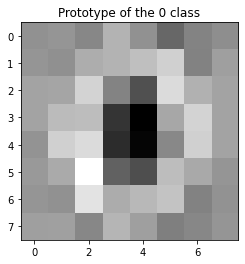

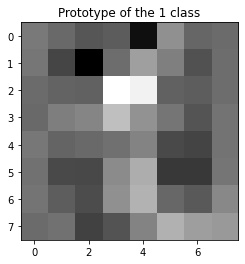

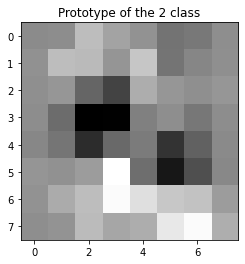

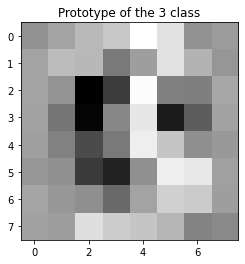

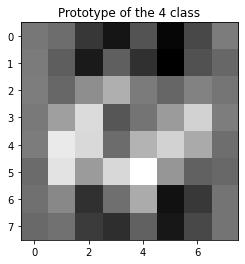

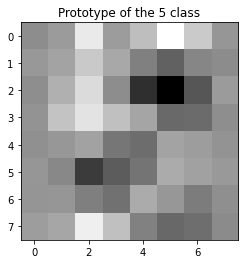

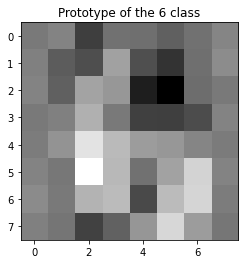

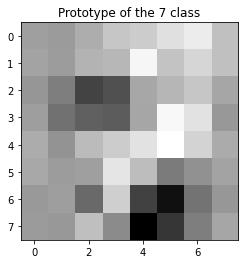

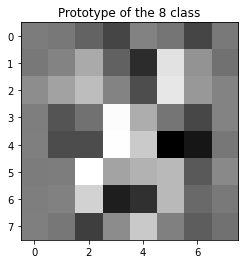

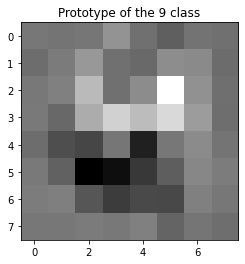

In [ ]:
learnt_bias = model.lin.bias.cpu().detach()
learnt_weights = model.lin.weight.cpu().detach()
print(f"Bias: {learnt_bias}")
for i in range(10):
  plt.imshow(learnt_weights[i].reshape((8, 8)), cmap="gray")
  plt.title(f"Prototype of the {i} class")
  plt.show()

Otherwise with more complex model you can still see the distribution of the classes as learnt by the model through some visualization techniques. Personally I like very much [t-sne](https://lvdmaaten.github.io/tsne/): it allows to project into low dimensional representation (e.g. 2D) data which lies in very high dimensional spaces. 

Here is an example on the weights learnt by the network:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


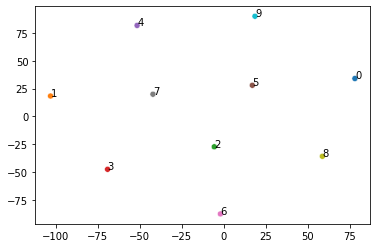

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
projected_weights = TSNE(n_components=2, init="pca", learning_rate='auto').fit_transform(learnt_weights)
sns.scatterplot(x=projected_weights[:,0], y=projected_weights[:,1], hue=(str(i) for i in range(10)), legend=False)
[plt.text(projected_weights[i,0], projected_weights[i,1], s=str(i)) for i in range(10)]
plt.show()

But you can do it for all the samples in the dataset as well!



In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
projected_samples = TSNE(n_components=2, init="pca", learning_rate='auto').fit_transform(x)
sns.scatterplot(x=projected_samples[:,0], y=projected_samples[:,1], hue=[str(y_i) for y_i in y])
plt.show()

## Closing thoughts

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. 

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.
